# Trashes Model Predict based on TACO Dataset and ImageAI lib

### Topics
1. **Exploratory Analysis**: Inspections on TACO dataset (Exploratory Analysis)

2. **Pre Processing**:       Conversion beetwen COCO and VOC PASCAL formats

3. **Pre Processing**:       Rescaling of TACO Dataset Images and Bounding Boxes parameters

4. **Training**      :       Training the model

### Requirements:
1. Image AI Lib Requirements: https://imageai.readthedocs.io/en/latest/#
2. Albumentations Lib Requirements: https://albumentations.ai/docs/getting_started/installation/
3. Open CV Libs
4. Taco Dataset: https://github.com/pedropro/TACO

### Instruction about the  TACO Dataset:
- See https://github.com/pedropro/TACO

#### Notebook Implemented by Tiago Sá
* Github: https://github.com/rTiagoS

In [38]:
# Libs

import json # To manipulate annotations json file
import xml.etree.ElementTree as ET # To generate the xml annotations


import numpy as np # To perform numeric operations on Digital Image Processing
import pandas as pd # To manipulate dataframes
import matplotlib.pyplot as plt # To visualize images
import random # To visualize and image


import os # To manipulate the dataset input/output in differents formats
import pathlib # To get in on user folders and directories

import cv2 # Computacional Vision manipulations on Images from Taco Dataset
import albumentations as A # To pre processing images and also bounding boxes parameters

%matplotlib inline

# Data Pre Processing

In [163]:
# Bounding Boxes Colors
BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White
dataset_format = 'coco'

def visualize_bbox(img, bbox, class_name, color=BOX_COLOR, thickness=2):
    """Visualizes a single bounding box on the image"""
    
    if (dataset_format == 'coco'):
        x_min, y_min, w, h = bbox
        x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)
    elif (dataset_format =='pascal_voc'):
        x_min, y_min, x_max, y_max = bbox
    else:
        print('Invalid Format')

    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)

    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35, 
        color=TEXT_COLOR, 
        lineType=cv2.LINE_AA,
    )
    return img


def visualize(image, bboxes, category_ids, category_id_to_name):
    img = image.copy()
    for bbox, category_id in zip(bboxes, category_ids):
        class_name = category_id_to_name[category_id]
        img = visualize_bbox(img, bbox, class_name)
    plt.figure(figsize=(12, 12))
    plt.axis('off')
    plt.imshow(img)

In [112]:
# Read annotations json file

dataset_path = '/home/trs/ML_Projects/Huawei_Curupira/Datasets/TACO/data'
anns_file_path = dataset_path + '/' + 'annotations.json'


with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())



In [98]:
def get_random_image(annotation_json_file):
    
    categories  = annotation_json_file['categories']
    annotations = annotation_json_file['annotations']
    images      = annotation_json_file['images']

    rand_number = random.randrange(0, len(images))
    
    image_path = images[rand_number]['file_name']
    image_path = dataset_path + '/' + image_path # Just an image path
    
    image = cv2.imread(image_path) # Read an image to show an example

    bboxes = []
    category_ids = []
    category_id_to_name = {}
    height = images[rand_number]['height']
    width = images[rand_number]['width']
    
    for i in range(0, len(annotations)):
        if (annotations[i]['image_id'] == rand_number):
            bboxes.append(
                [np.abs(annotations[i]['bbox'][0]),
                 np.abs(annotations[i]['bbox'][1]),
                 np.abs(annotations[i]['bbox'][2]),
                 np.abs(annotations[i]['bbox'][3])])

            category_ids.append(annotations[i]['category_id'])
    for key in category_ids:
        category_id_to_name[key] = '{}'.format(categories[key]['name'])
    
    return [image,
            bboxes,
            category_ids,
            category_id_to_name,
            height,
            width]


# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [99]:
img_obj = get_random_image(dataset)
image               = img_obj[0]
bboxes              = img_obj[1]
category_ids        = img_obj[2]
category_id_to_name = img_obj[3]
height              = img_obj[4]
width               = img_obj[5]

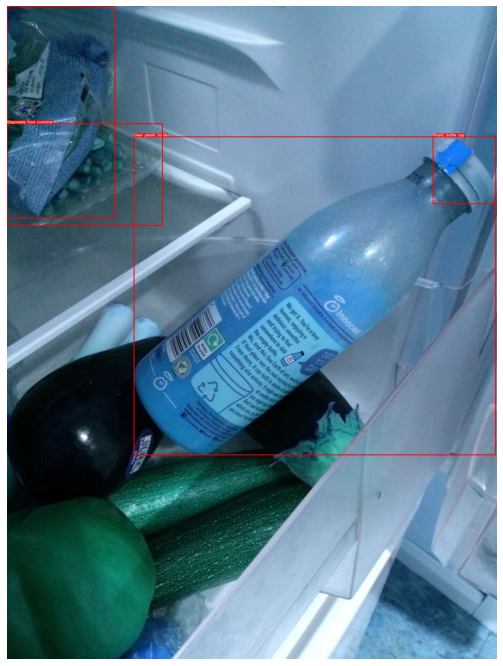

In [100]:
# Visualize the random image with associated bounding boxes
visualize(image, bboxes, category_ids, category_id_to_name)

In [104]:
# Creating the pipeline to apply a transformation to reduce the dimensionality of the
# original images. Resize from 100% to 20% (0.2 factor) 

transform = A.Compose([
    A.Resize(height = int(height*0.2), width = int(width*0.2), interpolation=1, always_apply=False, p=1)
], bbox_params=A.BboxParams(format='coco', label_fields=['category_ids'] ))

In [107]:
# Applying resizing (scalation) both on Images and Bounding Boxes

transformed = transform(image=image, bboxes=bboxes, category_ids = category_ids)
transformed_image = transformed['image']
transformed_bboxes = transformed['bboxes']
transformed_labels = transformed['category_ids']

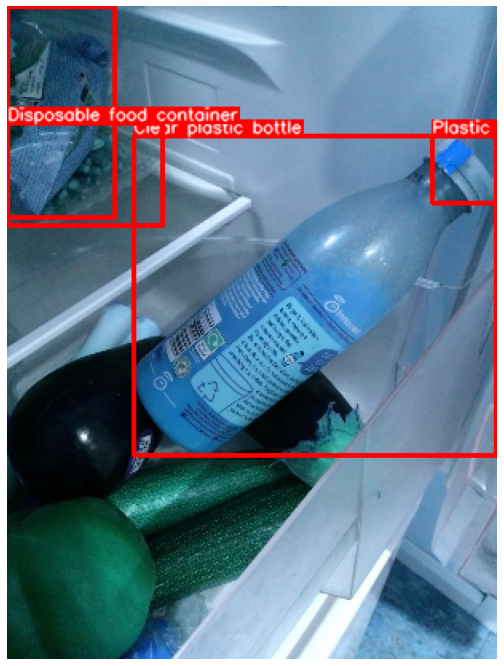

In [108]:
visualize(transformed_image, transformed_bboxes, transformed_labels, category_id_to_name )

In [407]:
# Let's resize all the the images from TACO Dataset and update the Bounding Boxes in the 
# annotatations json file as well

dataset_path = '/home/trs/ML_Projects/Huawei_Curupira/Datasets/TACO/data'
anns_file_path = dataset_path + '/' + 'annotations.json'

In [408]:

    
categories  = dataset['categories']
annotations = dataset['annotations']
images      = dataset['images']


In [132]:
def resize_and_update(anns_file_path):
    """Update the following parameters with the new scale: 
    1. Image Widht and Height;
    2. Bounding Boxes Parameters
    3. And also generate the images resized"""
    
    output_dir = dataset_path + '/resized_images'

    with open(anns_file_path, 'r') as f:
         annotation_json_file = json.loads(f.read())
    
    # Root directory of the dataset
    os.chdir(dataset_path)
    
    # Create the output_dir
    os.mkdir(output_dir)
    
    images      = annotation_json_file['images']
    annotations = annotation_json_file['annotations']
    categories  = annotation_json_file['categories']
    
    for k in range(0, len(images)): # Go through all the images
        
        # Update the height and width with the appropriate rescale factor.
        images[k]['width'] = int(images[k]['width']*0.10) 
        images[k]['height'] = int(images[k]['height']*0.10)
        
        # Read the image through the iterations
        image = cv2.imread('{}'.format(images[k]['file_name']))
        
        # Declaring arrays and dic to update postwards
        bboxes = []
        category_ids = []
        category_id_to_name ={}

        # Go through all the annotations
        for j in range(0, len(annotations)):
            if (annotations[j]['image_id'] == k): # When finding the correct iteration
                # Get the bounding boxes
                bboxes.append(
                    [np.abs(annotations[j]['bbox'][0]),
                    np.abs(annotations[j]['bbox'][1]),
                    np.abs(annotations[j]['bbox'][2]),
                    np.abs(annotations[j]['bbox'][3])])
                
                # Get the corresponding category id
                category_ids.append(annotations[j]['category_id'])
                
        for key in category_ids:
            # Get the corresponding label associated to the category id
            category_id_to_name[key] = '{}'.format(categories[key]['name'])
            
        # Apply the rescale transformation on the image and bounding boxes    
        transform = A.Compose([
            A.Resize(height = images[k]['height'], width = images[k]['width'],
                     interpolation=1, always_apply=False, p=1)
        ], bbox_params=A.BboxParams(format='coco', label_fields=['category_ids']))
        
        # Get the objects after the transformation is applied
        transformed = transform(image = image, bboxes = bboxes, category_ids = category_ids)
        transformed_image  = transformed['image']
        transformed_bboxes = transformed['bboxes']
        transformed_labels = transformed['category_ids']
        
        ## SECTION TO UPDATE THE BOUNDING BOXES ANNOTATIONS ## 
        i = 0
        for j in range(0, len(annotations)):
            if (annotations[j]['image_id'] == k):
                if (i < len(transformed_bboxes)):
                    annotations[j]['bbox'][0] = int(transformed_bboxes[i][0])
                    annotations[j]['bbox'][1] = int(transformed_bboxes[i][1])
                    annotations[j]['bbox'][2] = int(transformed_bboxes[i][2])
                    annotations[j]['bbox'][3] = int(transformed_bboxes[i][3])
                    i+=1
        
        # Save the images after the resize
        cv2.imwrite('{}/resized_images/{}'.format(dataset_path,'{:0>6}.jpg'.format(k)),
                    transformed_image)
        print('Image{} rescaled!'.format(k))
    
    print("Images rescaled successfully!\nAnnotation Json File updated succesfully!")
    return annotation_json_file

In [133]:
dataset = resize_and_update(anns_file_path)


Image0 rescaled!
Image1 rescaled!
Image2 rescaled!
Image3 rescaled!
Image4 rescaled!
Image5 rescaled!
Image6 rescaled!
Image7 rescaled!
Image8 rescaled!
Image9 rescaled!
Image10 rescaled!
Image11 rescaled!
Image12 rescaled!
Image13 rescaled!
Image14 rescaled!
Image15 rescaled!
Image16 rescaled!
Image17 rescaled!
Image18 rescaled!
Image19 rescaled!
Image20 rescaled!
Image21 rescaled!
Image22 rescaled!
Image23 rescaled!
Image24 rescaled!
Image25 rescaled!
Image26 rescaled!
Image27 rescaled!
Image28 rescaled!
Image29 rescaled!
Image30 rescaled!
Image31 rescaled!
Image32 rescaled!
Image33 rescaled!
Image34 rescaled!
Image35 rescaled!
Image36 rescaled!
Image37 rescaled!
Image38 rescaled!
Image39 rescaled!
Image40 rescaled!
Image41 rescaled!
Image42 rescaled!
Image43 rescaled!
Image44 rescaled!
Image45 rescaled!
Image46 rescaled!
Image47 rescaled!
Image48 rescaled!
Image49 rescaled!
Image50 rescaled!
Image51 rescaled!
Image52 rescaled!
Image53 rescaled!
Image54 rescaled!
Image55 rescaled!
Im

Image437 rescaled!
Image438 rescaled!
Image439 rescaled!
Image440 rescaled!
Image441 rescaled!
Image442 rescaled!
Image443 rescaled!
Image444 rescaled!
Image445 rescaled!
Image446 rescaled!
Image447 rescaled!
Image448 rescaled!
Image449 rescaled!
Image450 rescaled!
Image451 rescaled!
Image452 rescaled!
Image453 rescaled!
Image454 rescaled!
Image455 rescaled!
Image456 rescaled!
Image457 rescaled!
Image458 rescaled!
Image459 rescaled!
Image460 rescaled!
Image461 rescaled!
Image462 rescaled!
Image463 rescaled!
Image464 rescaled!
Image465 rescaled!
Image466 rescaled!
Image467 rescaled!
Image468 rescaled!
Image469 rescaled!
Image470 rescaled!
Image471 rescaled!
Image472 rescaled!
Image473 rescaled!
Image474 rescaled!
Image475 rescaled!
Image476 rescaled!
Image477 rescaled!
Image478 rescaled!
Image479 rescaled!
Image480 rescaled!
Image481 rescaled!
Image482 rescaled!
Image483 rescaled!
Image484 rescaled!
Image485 rescaled!
Image486 rescaled!
Image487 rescaled!
Image488 rescaled!
Image489 res

Image870 rescaled!
Image871 rescaled!
Image872 rescaled!
Image873 rescaled!
Image874 rescaled!
Image875 rescaled!
Image876 rescaled!
Image877 rescaled!
Image878 rescaled!
Image879 rescaled!
Image880 rescaled!
Image881 rescaled!
Image882 rescaled!
Image883 rescaled!
Image884 rescaled!
Image885 rescaled!
Image886 rescaled!
Image887 rescaled!
Image888 rescaled!
Image889 rescaled!
Image890 rescaled!
Image891 rescaled!
Image892 rescaled!
Image893 rescaled!
Image894 rescaled!
Image895 rescaled!
Image896 rescaled!
Image897 rescaled!
Image898 rescaled!
Image899 rescaled!
Image900 rescaled!
Image901 rescaled!
Image902 rescaled!
Image903 rescaled!
Image904 rescaled!
Image905 rescaled!
Image906 rescaled!
Image907 rescaled!
Image908 rescaled!
Image909 rescaled!
Image910 rescaled!
Image911 rescaled!
Image912 rescaled!
Image913 rescaled!
Image914 rescaled!
Image915 rescaled!
Image916 rescaled!
Image917 rescaled!
Image918 rescaled!
Image919 rescaled!
Image920 rescaled!
Image921 rescaled!
Image922 res

Image1287 rescaled!
Image1288 rescaled!
Image1289 rescaled!
Image1290 rescaled!
Image1291 rescaled!
Image1292 rescaled!
Image1293 rescaled!
Image1294 rescaled!
Image1295 rescaled!
Image1296 rescaled!
Image1297 rescaled!
Image1298 rescaled!
Image1299 rescaled!
Image1300 rescaled!
Image1301 rescaled!
Image1302 rescaled!
Image1303 rescaled!
Image1304 rescaled!
Image1305 rescaled!
Image1306 rescaled!
Image1307 rescaled!
Image1308 rescaled!
Image1309 rescaled!
Image1310 rescaled!
Image1311 rescaled!
Image1312 rescaled!
Image1313 rescaled!
Image1314 rescaled!
Image1315 rescaled!
Image1316 rescaled!
Image1317 rescaled!
Image1318 rescaled!
Image1319 rescaled!
Image1320 rescaled!
Image1321 rescaled!
Image1322 rescaled!
Image1323 rescaled!
Image1324 rescaled!
Image1325 rescaled!
Image1326 rescaled!
Image1327 rescaled!
Image1328 rescaled!
Image1329 rescaled!
Image1330 rescaled!
Image1331 rescaled!
Image1332 rescaled!
Image1333 rescaled!
Image1334 rescaled!
Image1335 rescaled!
Image1336 rescaled!


In [139]:
def gen_dataframe_filenames(annotation_json_file):
    """Generate a dataframe containing the original image filename and its associated 
    generated filename"""

    images = annotation_json_file['images']

    # Root directory of the dataset
    os.chdir(dataset_path)

    df_filenames = pd.DataFrame(columns = ['original_filename', 'corresponding_filename'])
    
    for i in range(0, len(images)):
    
        images_filename = images[i]['file_name'].split('/')[1]
        images_path = images[i]['file_name']
    
        df_buffer = pd.DataFrame([['{}'.format(images_filename),
                                   '{:0>6}.jpg'.format(i)]],
                                 columns = ['original_filename', 'corresponding_filename'])
    
        df_filenames = pd.concat([df_filenames, df_buffer]).reset_index(drop=True)
    return df_filenames

In [140]:
df_filenames = gen_dataframe_filenames(dataset)
df_filenames.head()

,original_filename,corresponding_filename
0,000006.jpg,000000.jpg
1,000008.jpg,000001.jpg
2,000010.jpg,000002.jpg
3,000019.jpg,000003.jpg
4,000026.jpg,000004.jpg


In [141]:
def coco_to_pascal(annotation_json_file, df_filenames):

    images_path = '/home/trs/ML_Projects/Huawei_Curupira/Datasets/TACO/data/images'
    output_dir = dataset_path + '/xml_annotations'

    # Root directory of the dataset
    os.chdir(dataset_path)
    
    # Create the output_dir
    os.mkdir(output_dir)

    # Root directory of the dataset
    os.chdir(output_dir)

    images = annotation_json_file['images']
    annotations = annotation_json_file['annotations']
    categories = annotation_json_file['categories']
 
    for i in range(0, len(images)):

        xml_annotation = ET.Element('annotation') 

        xml_folder = ET.SubElement(xml_annotation, 'folder')

        xml_filename = ET.SubElement(xml_annotation, 'filename')
        xml_filename.text = df_filenames['corresponding_filename'][i]

        xml_path = ET.SubElement(xml_annotation, 'path')
        xml_path.text = df_filenames['corresponding_filename'][i]
    
        xml_source = ET.SubElement(xml_annotation, 'source')
        xml_database = ET.SubElement(xml_source, 'database')
        xml_database.text = 'TACO Dataset'
    
        xml_size = ET.SubElement(xml_annotation, 'size')
        xml_width = ET.SubElement(xml_size, 'width')
        xml_height = ET.SubElement(xml_size, 'height')
        xml_depth = ET.SubElement(xml_size, 'depth')
        xml_width.text = '{}'.format(images[i]['width'])
        xml_height.text = '{}'.format(images[i]['height'])
        xml_depth.text = '3'
    
        xml_segmented = ET.SubElement(xml_annotation, 'segmented')
        xml_segmented.text = '0'
    
        ####### OBJECT PART #######
    
        for j in range(0, len(annotations)):
            if (annotations[j]['image_id'] == i):
                xml_object = ET.SubElement(xml_annotation, 'object')
                xml_name = ET.SubElement(xml_object, 'name')
                xml_pose = ET.SubElement(xml_object, 'pose')
                xml_truncated = ET.SubElement(xml_object, 'truncated')
                xml_difficult = ET.SubElement(xml_object, 'difficult')
                xml_occluded = ET.SubElement(xml_object, 'occluded')

                xml_bndbox  = ET.SubElement(xml_object, 'bndbox')       
                xml_xmin = ET.SubElement(xml_bndbox, 'xmin')
                xml_ymin = ET.SubElement(xml_bndbox, 'ymin')
                xml_xmax = ET.SubElement(xml_bndbox, 'xmax')
                xml_ymax = ET.SubElement(xml_bndbox, 'ymax')

            

                category_id = annotations[j]['category_id']

                xml_name.text = categories[category_id]['name']
                xml_pose.text = 'Unspecified'
                xml_truncated.text = '0'
                xml_difficult.text = '0'
                xml_occluded.text = '0'
                
                # Conversion between COCO and PASCAL VOC formats
                xml_xmin.text = '{}'.format(int(annotations[j]['bbox'][0]))
                xml_ymin.text = '{}'.format(int(annotations[j]['bbox'][1]))
                xml_xmax.text = '{}'.format(int(annotations[j]['bbox'][2] +
                                                annotations[j]['bbox'][0]))
                xml_ymax.text = '{}'.format(int(annotations[j]['bbox'][3] +
                                                annotations[j]['bbox'][1]))

        
        b_xml = ET.tostring(xml_annotation) 

        # Save the xml pascal voc format file
        with open("{}.xml".format(df_filenames['corresponding_filename'][i].split('.')[0]), "wb") as f: 
            f.write(b_xml)
        
        print('Pascal Voc {} generated!'.format(i))
    
    print("xml files generated succesfully")

In [143]:
coco_to_pascal(dataset, df_filenames)

Pascal Voc 0 generated!
Pascal Voc 1 generated!
Pascal Voc 2 generated!
Pascal Voc 3 generated!
Pascal Voc 4 generated!
Pascal Voc 5 generated!
Pascal Voc 6 generated!
Pascal Voc 7 generated!
Pascal Voc 8 generated!
Pascal Voc 9 generated!
Pascal Voc 10 generated!
Pascal Voc 11 generated!
Pascal Voc 12 generated!
Pascal Voc 13 generated!
Pascal Voc 14 generated!
Pascal Voc 15 generated!
Pascal Voc 16 generated!
Pascal Voc 17 generated!
Pascal Voc 18 generated!
Pascal Voc 19 generated!
Pascal Voc 20 generated!
Pascal Voc 21 generated!
Pascal Voc 22 generated!
Pascal Voc 23 generated!
Pascal Voc 24 generated!
Pascal Voc 25 generated!
Pascal Voc 26 generated!
Pascal Voc 27 generated!
Pascal Voc 28 generated!
Pascal Voc 29 generated!
Pascal Voc 30 generated!
Pascal Voc 31 generated!
Pascal Voc 32 generated!
Pascal Voc 33 generated!
Pascal Voc 34 generated!
Pascal Voc 35 generated!
Pascal Voc 36 generated!
Pascal Voc 37 generated!
Pascal Voc 38 generated!
Pascal Voc 39 generated!
Pascal Voc

Pascal Voc 367 generated!
Pascal Voc 368 generated!
Pascal Voc 369 generated!
Pascal Voc 370 generated!
Pascal Voc 371 generated!
Pascal Voc 372 generated!
Pascal Voc 373 generated!
Pascal Voc 374 generated!
Pascal Voc 375 generated!
Pascal Voc 376 generated!
Pascal Voc 377 generated!
Pascal Voc 378 generated!
Pascal Voc 379 generated!
Pascal Voc 380 generated!
Pascal Voc 381 generated!
Pascal Voc 382 generated!
Pascal Voc 383 generated!
Pascal Voc 384 generated!
Pascal Voc 385 generated!
Pascal Voc 386 generated!
Pascal Voc 387 generated!
Pascal Voc 388 generated!
Pascal Voc 389 generated!
Pascal Voc 390 generated!
Pascal Voc 391 generated!
Pascal Voc 392 generated!
Pascal Voc 393 generated!
Pascal Voc 394 generated!
Pascal Voc 395 generated!
Pascal Voc 396 generated!
Pascal Voc 397 generated!
Pascal Voc 398 generated!
Pascal Voc 399 generated!
Pascal Voc 400 generated!
Pascal Voc 401 generated!
Pascal Voc 402 generated!
Pascal Voc 403 generated!
Pascal Voc 404 generated!
Pascal Voc 4

Pascal Voc 765 generated!
Pascal Voc 766 generated!
Pascal Voc 767 generated!
Pascal Voc 768 generated!
Pascal Voc 769 generated!
Pascal Voc 770 generated!
Pascal Voc 771 generated!
Pascal Voc 772 generated!
Pascal Voc 773 generated!
Pascal Voc 774 generated!
Pascal Voc 775 generated!
Pascal Voc 776 generated!
Pascal Voc 777 generated!
Pascal Voc 778 generated!
Pascal Voc 779 generated!
Pascal Voc 780 generated!
Pascal Voc 781 generated!
Pascal Voc 782 generated!
Pascal Voc 783 generated!
Pascal Voc 784 generated!
Pascal Voc 785 generated!
Pascal Voc 786 generated!
Pascal Voc 787 generated!
Pascal Voc 788 generated!
Pascal Voc 789 generated!
Pascal Voc 790 generated!
Pascal Voc 791 generated!
Pascal Voc 792 generated!
Pascal Voc 793 generated!
Pascal Voc 794 generated!
Pascal Voc 795 generated!
Pascal Voc 796 generated!
Pascal Voc 797 generated!
Pascal Voc 798 generated!
Pascal Voc 799 generated!
Pascal Voc 800 generated!
Pascal Voc 801 generated!
Pascal Voc 802 generated!
Pascal Voc 8

Pascal Voc 1129 generated!
Pascal Voc 1130 generated!
Pascal Voc 1131 generated!
Pascal Voc 1132 generated!
Pascal Voc 1133 generated!
Pascal Voc 1134 generated!
Pascal Voc 1135 generated!
Pascal Voc 1136 generated!
Pascal Voc 1137 generated!
Pascal Voc 1138 generated!
Pascal Voc 1139 generated!
Pascal Voc 1140 generated!
Pascal Voc 1141 generated!
Pascal Voc 1142 generated!
Pascal Voc 1143 generated!
Pascal Voc 1144 generated!
Pascal Voc 1145 generated!
Pascal Voc 1146 generated!
Pascal Voc 1147 generated!
Pascal Voc 1148 generated!
Pascal Voc 1149 generated!
Pascal Voc 1150 generated!
Pascal Voc 1151 generated!
Pascal Voc 1152 generated!
Pascal Voc 1153 generated!
Pascal Voc 1154 generated!
Pascal Voc 1155 generated!
Pascal Voc 1156 generated!
Pascal Voc 1157 generated!
Pascal Voc 1158 generated!
Pascal Voc 1159 generated!
Pascal Voc 1160 generated!
Pascal Voc 1161 generated!
Pascal Voc 1162 generated!
Pascal Voc 1163 generated!
Pascal Voc 1164 generated!
Pascal Voc 1165 generated!
P

Pascal Voc 1481 generated!
Pascal Voc 1482 generated!
Pascal Voc 1483 generated!
Pascal Voc 1484 generated!
Pascal Voc 1485 generated!
Pascal Voc 1486 generated!
Pascal Voc 1487 generated!
Pascal Voc 1488 generated!
Pascal Voc 1489 generated!
Pascal Voc 1490 generated!
Pascal Voc 1491 generated!
Pascal Voc 1492 generated!
Pascal Voc 1493 generated!
Pascal Voc 1494 generated!
Pascal Voc 1495 generated!
Pascal Voc 1496 generated!
Pascal Voc 1497 generated!
Pascal Voc 1498 generated!
Pascal Voc 1499 generated!
xml files generated succesfully


In [152]:
dataset['annotations'][0]['bbox']

[51, 12, 44, 131]

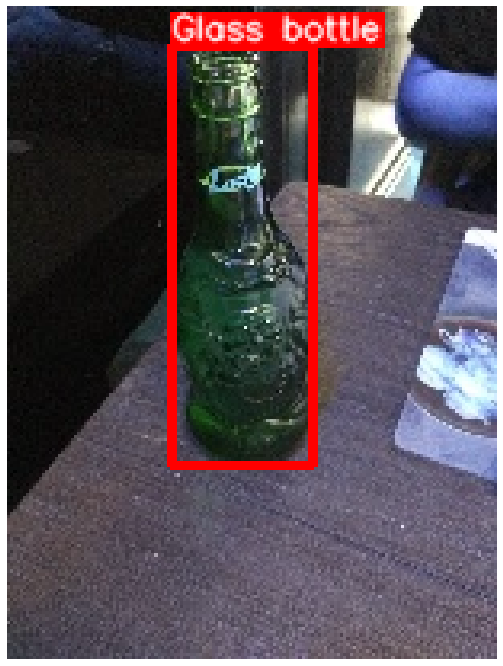

In [165]:
# Let's check if the xml files were correctly generated through a visualization

#Choosing an arbitrary image
image_filename = '000000.jpg'
image_path = dataset_path + '/resized_images/' + image_filename
image = cv2.imread(image_path)

# Change the dataset_format visualization
dataset_format = 'pascal_voc' 

# I manually got the bounding box at the xml folder
bboxes = [[51, 12, 95, 143]]
category_ids = [6]
category_id_to_name = {6: 'Glass bottle'}

visualize(image, bboxes, category_ids, category_id_to_name)

In [175]:
# Checking if there are some categories label that are not used:

categories_labels = []
for i in range(0, len(annotations)):
    categories_labels.append(annotations[i]['category_id'])

# Realize that 35 it's present
np.unique(categories_labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59])

In [183]:
categories_labels = []
for i in range(0, len(categories)):
    categories_labels.append(categories[i]['name'])
categories_labels.pop(35)
len(categories_labels)

59

In [417]:
from imageai.Detection.Custom import DetectionModelTrainer

# Training 

In [436]:
# The code below follows according to the Image AI Custom Detection Model Documentation
# more info: 
# https://github.com/OlafenwaMoses/ImageAI/blob/master/imageai/Detection/Custom/CUSTOMDETECTIONTRAINING.md

trainer = DetectionModelTrainer() 
trainer.setModelTypeAsYOLOv3()
trainer.setDataDirectory(data_directory ='/home/trs/ML_Projects/Huawei_Curupira/Datasets/TACO/data/dataset_voc_format/')
trainer.setTrainConfig(object_names_array=categories_labels, batch_size=4, num_experiments = 50)
trainer.trainModel()

Generating anchor boxes for training images and annotation...
Average IOU for 9 anchors: 0.57
Anchor Boxes generated.
Detection configuration saved in  /home/trs/ML_Projects/Huawei_Curupira/Datasets/TACO/data/dataset_voc_format/json/detection_config.json
Evaluating over 300 samples taken from /home/trs/ML_Projects/Huawei_Curupira/Datasets/TACO/data/dataset_voc_format/validation
Training over 1200 samples  given at /home/trs/ML_Projects/Huawei_Curupira/Datasets/TACO/data/dataset_voc_format/train
Training on: 	['Aerosol', 'Aluminium blister pack', 'Aluminium foil', 'Battery', 'Broken glass', 'Carded blister pack', 'Cigarette', 'Clear plastic bottle', 'Corrugated carton', 'Crisp packet', 'Disposable food container', 'Disposable plastic cup', 'Drink can', 'Drink carton', 'Egg carton', 'Foam cup', 'Foam food container', 'Food Can', 'Food waste', 'Garbage bag', 'Glass bottle', 'Glass cup', 'Glass jar', 'Magazine paper', 'Meal carton', 'Metal bottle cap', 'Metal lid', 'Normal paper', 'Other c

ResourceExhaustedError: OOM when allocating tensor with shape[1,1792,1792,1,2] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:ConcatV2] name: concat